# Détection d'objets pour edgeTPU : détection de form pour tictactoe 2021

Ce notebook permet d'utiliser un réseau de neurones entrainer avec tensorflow 1 sur TPU (ici sur NUC)

#### Ce notebook est inspirer du code ici : https://github.com/google-coral/pycoral/blob/master/examples/detect_image.pyavec qui nécessite l'installation de *tflite_runtime* et l'API *pycoral*  

In [2]:
import numpy as np 
import matplotlib.pyplot as plt 

import cv2 as cv 
from PIL import Image 

import time

#from pycoral.adapters import classify, common
#from pycoral.utils.edgetpu import make_interpreter
#from pycoral.utils.dataset import read_label_file

from tflite_runtime.interpreter import Interpreter
from tflite_runtime.interpreter import load_delegate

from reachy_sdk import ReachySDK

from reachy_sdk.trajectory import goto
from reachy_sdk.trajectory.interpolation import InterpolationMode

#import argparse

from PIL import ImageDraw

from pycoral.adapters import detect
from pycoral.utils.dataset import read_label_file
from pycoral.utils.edgetpu import make_interpreter

In [3]:
reachy = ReachySDK('localhost')

In [4]:
board_cases = np.array((
    ((86, 169, 388, 464), #Coordinates first board cases (top-left corner) (Xbl, Xbr, Ytr, Ybr)
     (169, 261, 388, 464), #Coordinates second board cases
     (261, 354, 388, 464),),

    ((77, 167, 446, 547),
     (167, 268, 446, 547),
     (268, 365, 446, 547),),

    ((70, 164, 551, 629),
     (164, 270, 551, 629),
     (270, 375, 551, 629),),
))

# left, right, top, bottom
board_rect = np.array((
    67, 375, 374, 629,
))

Pour dessiner les boxes sur les images : 

In [7]:
def draw_objects(draw, objs, labels):
#Draws the bounding box and label for each object.
#for obj in objs:
    obj = objs[0]
    bbox = obj.bbox
    draw.rectangle([(bbox.xmin, bbox.ymin), (bbox.xmax, bbox.ymax)],
                   outline='red')
    draw.text((bbox.xmin + 10, bbox.ymin + 10),
              '%s\n%.2f' % (labels.get(obj.id, obj.id), obj.score),
              fill='red')

Pour tester la détection des cube, cylindres et cases vides ont peut lancer un code sur une image : 

In [45]:
path_model = '/home/reachy/Desktop/tflite/output_tflite_graph_edgetpu.tflite'
path_label = '/home/reachy/Desktop/tflite/label.txt'

labels = read_label_file(path_label) if path_label else {}
interpreter = make_interpreter(path_model)
interpreter.allocate_tensors()

image = reachy.right_camera.wait_for_new_frame()
_, scale = common.set_resized_input(interpreter, image.size, lambda size: image.resize(size, Image.ANTIALIAS))


args_count = 5
args_threshold = 0.5

for _ in range(args_count):
    start = time.perf_counter()
    interpreter.invoke()
    inference_time = time.perf_counter() - start
    objs = detect.get_objects(interpreter, args_threshold, scale)
    print('%.2f ms' % (inference_time * 1000))

print('-------RESULTS--------')
if not objs:
    print('No objects detected')

for obj in objs:
    #obj = objs[0]
    print(labels.get(obj.id, obj.id))
    print('  id:    ', obj.id)
    print('  score: ', obj.score)
    print('  bbox:  ', obj.bbox)

image = image.convert('RGB')
draw_objects(ImageDraw.Draw(image), objs, labels)
image.save('image.png')
image.show()


18.48 ms
6.17 ms
6.77 ms
9.71 ms
6.25 ms
-------RESULTS--------
cylinder
  id:     2
  score:  0.875
  bbox:   BBox(xmin=39, ymin=-4, xmax=178, ymax=137)


In [6]:
reachy.turn_off('reachy')

Pour tester la detection de facons plus intéractive on peut lancer la détection sur une vidéo est bouger les pions pendant que le programme tourne : 

In [5]:
im = reachy.right_camera.wait_for_new_frame()
height, width = np.shape(im)[:2]

In [8]:
video = cv.VideoWriter('tuto_classification400.avi',cv.VideoWriter_fourcc('M','J','P','G'), 5,(width,height))

reachy.turn_on('head')
reachy.head.look_at(x=1, y=0, z=0, duration=1.5)  
time.sleep(1.5)

reachy.head.look_at(x=0.75, y=0, z=-0.4, duration=1.5) 
path_model = '/home/reachy/Desktop/tflite/output_tflite_graph_edgetpu.tflite'
path_label = '/home/reachy/Desktop/tflite/label.txt'

labels = read_label_file(path_label) if path_label else {}
interpreter = make_interpreter(path_model)
interpreter.allocate_tensors()

start = time.time()
fps_count = 0
nb = 1
while time.time() - start < 15:
    
    print(f'temps : {time.time() - start}')
    im = reachy.right_camera.wait_for_new_frame()
    out = im.copy()
            
    image = Image.fromarray(out[ly:ry, lx:rx])
    image.save(f'/home/reachy/Desktop/image{nb}.png')
    nb = nb+1
    _, scale = common.set_resized_input(interpreter, image.size, lambda size: image.resize(size, Image.ANTIALIAS))

    args_count = 1
    args_threshold = 0.5

    for _ in range(args_count):
        start2 = time.perf_counter()
        interpreter.invoke()
        inference_time = time.perf_counter() - start2
        objs = detect.get_objects(interpreter, args_threshold, scale)
        print('%.2f ms' % (inference_time * 1000))

    print('-------RESULTS--------')
    if not objs:
        print('No objects detected')

    #for obj in objs:
    obj = objs[0]
    print(labels.get(obj.id, obj.id))
    print('  id:    ', obj.id)
    print('  score: ', obj.score)
    print('  bbox:  ', obj.bbox)
    
    #label = 'pouet'
    #if (obj.id == 0):
    #    label = 'empty'
    #if (obj.id == 1):
    #    label = 'cube'
    #if (obj.id == 2):
    #    label = 'cylinder'

    #image = image.convert('RGB')
    draw_objects(ImageDraw.Draw(image), objs, labels)
    #image.save('image.png')
    #image.show()
            
    #label = labels.get(result[0].id)
    #cv.putText(out, label, (int((lx+rx)/2)-30, int((ly+ry)/2)), cv.FONT_HERSHEY_SIMPLEX, 0.75, (255,0,0), 2)
    #cv.rectangle(out, (lx, ly), (rx, ry), (0, 255, 0), 5)
    #time.sleep(5)
    video.write(out)        
            
video.release()

reachy.head.look_at(0.5, 0, 0, duration=1)
time.sleep(0.2)

temps : 0.00041413307189941406
26.84 ms
-------RESULTS--------
cube
  id:     1
  score:  0.9296875
  bbox:   BBox(xmin=0, ymin=3, xmax=78, ymax=77)
6.20 ms
-------RESULTS--------
cube
  id:     1
  score:  0.65625
  bbox:   BBox(xmin=-1, ymin=13, xmax=85, ymax=89)
6.14 ms
-------RESULTS--------
cube
  id:     1
  score:  0.65625
  bbox:   BBox(xmin=0, ymin=63, xmax=84, ymax=95)
6.16 ms
-------RESULTS--------
cube
  id:     1
  score:  0.875
  bbox:   BBox(xmin=14, ymin=12, xmax=86, ymax=83)
6.68 ms
-------RESULTS--------
cube
  id:     1
  score:  0.96484375
  bbox:   BBox(xmin=7, ymin=15, xmax=89, ymax=74)
9.33 ms
-------RESULTS--------
cube
  id:     1
  score:  0.9296875
  bbox:   BBox(xmin=-3, ymin=14, xmax=80, ymax=76)
11.17 ms
-------RESULTS--------
cube
  id:     1
  score:  0.9296875
  bbox:   BBox(xmin=1, ymin=3, xmax=92, ymax=78)
8.60 ms
-------RESULTS--------
cube
  id:     1
  score:  0.9296875
  bbox:   BBox(xmin=-2, ymin=6, xmax=97, ymax=82)
11.07 ms
-------RESULTS------

10.35 ms
-------RESULTS--------
empty
  id:     0
  score:  0.78515625
  bbox:   BBox(xmin=2, ymin=47, xmax=87, ymax=102)
7.25 ms
-------RESULTS--------
empty
  id:     0
  score:  0.78515625
  bbox:   BBox(xmin=2, ymin=30, xmax=88, ymax=95)
7.46 ms
-------RESULTS--------
cube
  id:     1
  score:  0.78515625
  bbox:   BBox(xmin=28, ymin=20, xmax=95, ymax=96)
7.34 ms
-------RESULTS--------
cube
  id:     1
  score:  0.78515625
  bbox:   BBox(xmin=30, ymin=21, xmax=95, ymax=95)
temps : 4.236771821975708
6.68 ms
-------RESULTS--------
empty
  id:     0
  score:  0.78515625
  bbox:   BBox(xmin=6, ymin=29, xmax=80, ymax=82)
31.24 ms
-------RESULTS--------
cylinder
  id:     2
  score:  0.65625
  bbox:   BBox(xmin=17, ymin=18, xmax=78, ymax=79)
7.75 ms
-------RESULTS--------
empty
  id:     0
  score:  0.65625
  bbox:   BBox(xmin=0, ymin=26, xmax=82, ymax=91)
6.25 ms
-------RESULTS--------
empty
  id:     0
  score:  0.875
  bbox:   BBox(xmin=8, ymin=48, xmax=89, ymax=103)
41.54 ms
-------R

6.25 ms
-------RESULTS--------
empty
  id:     0
  score:  0.78515625
  bbox:   BBox(xmin=7, ymin=31, xmax=80, ymax=83)
23.19 ms
-------RESULTS--------
cylinder
  id:     2
  score:  0.875
  bbox:   BBox(xmin=17, ymin=16, xmax=80, ymax=77)
6.75 ms
-------RESULTS--------
empty
  id:     0
  score:  0.5
  bbox:   BBox(xmin=3, ymin=22, xmax=80, ymax=86)
39.28 ms
-------RESULTS--------
empty
  id:     0
  score:  0.9296875
  bbox:   BBox(xmin=8, ymin=44, xmax=90, ymax=102)
9.51 ms
-------RESULTS--------
cube
  id:     1
  score:  0.96484375
  bbox:   BBox(xmin=12, ymin=38, xmax=79, ymax=99)
30.98 ms
-------RESULTS--------
empty
  id:     0
  score:  0.78515625
  bbox:   BBox(xmin=2, ymin=49, xmax=87, ymax=100)
16.57 ms
-------RESULTS--------
empty
  id:     0
  score:  0.78515625
  bbox:   BBox(xmin=4, ymin=29, xmax=87, ymax=94)
7.38 ms
-------RESULTS--------
empty
  id:     0
  score:  0.78515625
  bbox:   BBox(xmin=1, ymin=31, xmax=96, ymax=105)
6.25 ms
-------RESULTS--------
empty
  id:

8.54 ms
-------RESULTS--------
empty
  id:     0
  score:  0.78515625
  bbox:   BBox(xmin=6, ymin=29, xmax=90, ymax=94)
7.58 ms
-------RESULTS--------
empty
  id:     0
  score:  0.78515625
  bbox:   BBox(xmin=0, ymin=28, xmax=93, ymax=104)
9.86 ms
-------RESULTS--------
cube
  id:     1
  score:  0.78515625
  bbox:   BBox(xmin=26, ymin=22, xmax=96, ymax=88)
temps : 11.975196838378906
23.70 ms
-------RESULTS--------
empty
  id:     0
  score:  0.65625
  bbox:   BBox(xmin=6, ymin=31, xmax=77, ymax=82)
12.09 ms
-------RESULTS--------
cylinder
  id:     2
  score:  0.9296875
  bbox:   BBox(xmin=16, ymin=16, xmax=80, ymax=77)
8.48 ms
-------RESULTS--------
empty
  id:     0
  score:  0.65625
  bbox:   BBox(xmin=1, ymin=25, xmax=81, ymax=91)
18.52 ms
-------RESULTS--------
empty
  id:     0
  score:  0.9296875
  bbox:   BBox(xmin=10, ymin=41, xmax=88, ymax=103)
13.75 ms
-------RESULTS--------
cube
  id:     1
  score:  0.96484375
  bbox:   BBox(xmin=11, ymin=39, xmax=82, ymax=99)
7.21 ms
--

Pour générer des images pour l'entrainement : 

In [25]:
nb=1

In [45]:
# Get an image and check if the board is in the image

reachy.turn_on('head')
reachy.head.look_at(x=1, y=0, z=0, duration=1.5)  

time.sleep(1.0)

reachy.head.look_at(x=0.75, y=0, z=-0.6, duration=1.5) 
#you can adjust the z parameter to get the board in the image

#_, img = reachy.head.right_camera.read()
img = reachy.right_camera.wait_for_new_frame()
time.sleep(1.0)

reachy.head.look_at(x=1, y=0, z=0, duration=1.5)  

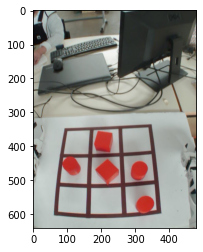

In [46]:
# Visualize what Reachy saw, adjust z parameter in the look_at until you see the whole board.

plt.figure()
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
#dst = cv2.cvtColor(src, code)

In [47]:
img = Image.fromarray(img)
img.save(f'/home/reachy/Desktop/images/image{nb}.png')
nb = nb+1

In [48]:
reachy.turn_off('reachy')